## Objective

We create a portfolio of stocks from American markets, analyze their performance and try to acess the risk in future.


### Building the porfolio

We will build a tech dominant portfolio to analyze including companies like Apple, Microsoft, Google etc.



In [31]:
import yfinance as yf
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np 
from ipywidgets import interact
import pandas as pd 

output_mf = widgets.Output()

# List of stock symbols
tech_stocks = ['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'META']

# Set the date range for the historical data
start_date = '2020-08-01'
end_date = '2023-08-01'

# Download historical stock data for each stock

all_data = yf.download(tech_stocks, start_date, end_date)['Close']



[*********************100%%**********************]  5 of 5 completed


To assign the weight of each of the company stock we calculate the market capitalisation.
To get the market value we need to know the last price of the security traded and the number of shares outstanding. yfinance gives the market cap directly.

For this, it is important to have a benchmark that can be used as a reference for the securities.

In [15]:
totalmp = 0
mcap=[]
for stock in tech_stocks:
    # Create a Ticker object
    # Create a Ticker object
    ticker = yf.Ticker(stock)

    # Fetch company information
    company_info = ticker.info

    # Get the market capitalization
    market_cap = company_info.get('marketCap', None)
    mcap.append(market_cap)
    totalmp += market_cap

weights = [mc/totalmp for mc in mcap]
print(weights)

[0.31637853258658555, 0.2614657347071365, 0.1529234346450335, 0.1863257951934117, 0.08290650286783274]


In [32]:

# get daily returns for each stock
daily_return = all_data.pct_change()

### Portfolio standard deviation

$\sigma_{port} = \sqrt{w_{t}\Sigma w}$

$\Sigma$ is covariance matrix and w's are weights 

In [33]:
# covariance of stocks
cov_matrix = daily_return.cov()

# Annual portfolio covariance
cov_annual = cov_matrix * 252

# portfolio standard deviation

port_std = np.sqrt(np.dot(np.array(weights).T, np.dot(cov_annual, np.array(weights))))

print(f"portfolio standard deviation is  {port_std*100:0.2f}%")

portfolio standard deviation is  30.37%


## Capital  asset  Pricing  model

- Its major  assumptions  are  that  the  offer  of  financial  assets  is  equal  to  the demand of financial assets.

- Only deals with systematic risk (market risk), that can't be reduced. 

$Total \ risk = systematic \ risk + non-systematic \ risk$

### Beta

Systematic risk can be measure by beta,  which is a degree of sensitivity that includes the variation of an asset compared with an index that is used as a benchmark.

$\beta_{i} = \rho_{im}\frac{\sigma_{i}}{\sigma_{m}} = \frac{cov(i,m)}{\sigma_{m}}$

$\rho_{im}$   =  Correlation between asset i and the market

$\sigma_{i}$   =  variance of asset i
$\sigma_{m}$   =  variance of the market
$cov_{(i,m)}$ =  covariance of assets i and market

### Testing for normality 

The Jarque-bera test can be used to compare the skewness and kurtosis of both data sets against that of the normal distribution. In contrast the KS test and Anderson-Darling tests can be used to compare the goodness of fit of the data to the normal distribution.

We start with first the visualisation

<Axes: xlabel='Date'>

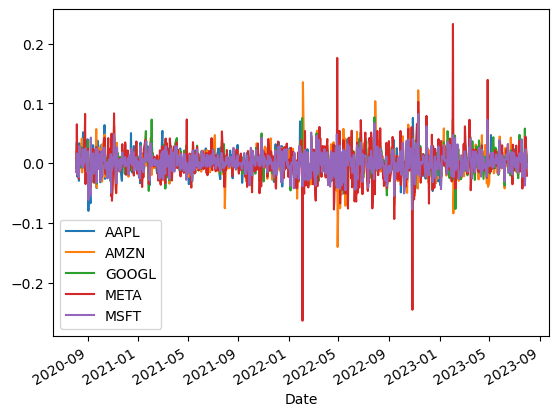

In [20]:
daily_return.plot()

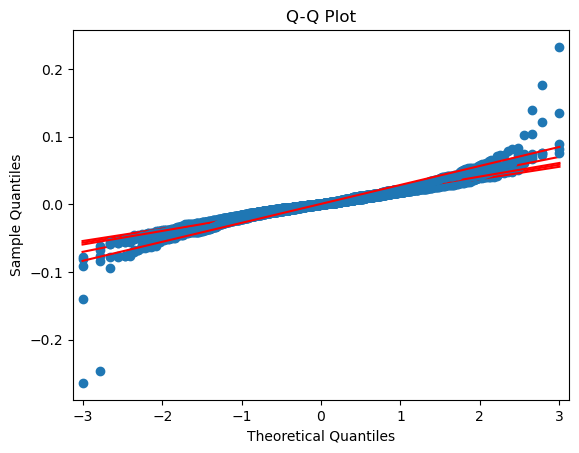

In [21]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1,1)
ax.set_xlabel(r'Returns')
ax.set_ylabel(r'Probability')

for stock in tech_stocks:
    # Q-Q Plot
    returns = daily_return[stock][1:]
    sm.qqplot(returns, line="r", ax=ax)
    ax.set_title("Q-Q Plot")


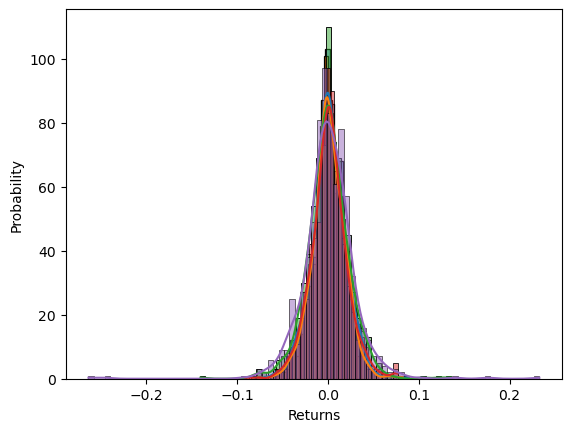

In [22]:
import seaborn as sns
fig,ax = plt.subplots(1,1)
ax.set_xlabel(r'Returns')
ax.set_ylabel(r'Probability')
for stock in tech_stocks:
    returns = daily_return[stock][1:]
    sns.histplot(returns,ax=ax,alpha=0.5,kde=True)

plt.show()

In [23]:
from scipy import stats
# Jarque-Bera test

for stock in tech_stocks:
    returns = daily_return[stock][1:]
        
    # Perform Jarque-Bera test
    jb_statistic, jb_p_value = stats.jarque_bera(returns)

    # Perform Kolmogorov-Smirnov test
    ks_statistic, ks_p_value = stats.kstest(returns, 'norm')

    # Perform Anderson-Darling test
    ad_statistic, ad_critical_values, ad_significance_levels = stats.anderson(returns)

    # Print test results
    print("Jarque-Bera Test:")
    print(f"Test Statistic: {jb_statistic:.4f}")
    print(f"P-value: {jb_p_value:.4f}")
    if jb_p_value < 0.05:
        print("The data does not follow a normal distribution.")
    else:
        print("The data follows a normal distribution.")
    print()

    print("Kolmogorov-Smirnov Test:")
    print(f"Test Statistic: {ks_statistic:.4f}")
    print(f"P-value: {ks_p_value:.4f}")
    if ks_p_value < 0.05:
        print("The data does not follow a normal distribution.")
    else:
        print("The data follows a normal distribution.")
    print()

    print("Anderson-Darling Test:")
    for i, (level, cv) in enumerate(zip(ad_significance_levels, ad_critical_values)):
        if ad_statistic < cv:
            print(f"Level {level}: The data follows a normal distribution.")
        else:
            print(f"Level {level}: The data does not follow a normal distribution.")


Jarque-Bera Test:
Test Statistic: 73.5722
P-value: 0.0000
The data does not follow a normal distribution.

Kolmogorov-Smirnov Test:
Test Statistic: 0.4739
P-value: 0.0000
The data does not follow a normal distribution.

Anderson-Darling Test:
Level 15.0: The data does not follow a normal distribution.
Level 10.0: The data does not follow a normal distribution.
Level 5.0: The data does not follow a normal distribution.
Level 2.5: The data does not follow a normal distribution.
Level 1.0: The data does not follow a normal distribution.
Jarque-Bera Test:
Test Statistic: 66.7746
P-value: 0.0000
The data does not follow a normal distribution.

Kolmogorov-Smirnov Test:
Test Statistic: 0.4754
P-value: 0.0000
The data does not follow a normal distribution.

Anderson-Darling Test:
Level 15.0: The data does not follow a normal distribution.
Level 10.0: The data does not follow a normal distribution.
Level 5.0: The data does not follow a normal distribution.
Level 2.5: The data does not follow a 

- Since the data shows that the returns are not normally distributed we can still use historical VAR to get idea of potential risks

### Historical VAR


Historical Value at Risk (VaR) is a risk measurement technique that is based on historical data and does not assume any specific probability distribution for returns. However, there are some key assumptions and limitations associated with the historical VaR approach:

- Assumption of Stationarity: mean and volatility, are relatively stable over time.

- Normality Assumption: the distribution of returns is similar to the observed historical distribution. 

- Assumption of No Changes in Market Conditions: the historical data are similar to the conditions that will prevail in the future. 

- Dependency Assumption: It assumes that asset returns are independent and identically distributed, which might not be true in reality.

- Limited Sample Size: Historical VaR relies on a limited number of observations from historical data, which might not capture all possible market scenarios. 

- Non-Reactivity to Changes: It provides a backward-looking measure and may not reflect current market conditions.

- Lack of Tail Detail: Historical VaR does not provide detailed information about extreme tail events. 

- Data Quality and Reliability: Historical VaR is highly sensitive to the quality, accuracy, and completeness of historical data. Using low-quality data can lead to misleading risk estimates.


In [24]:

# get portfolio return
portfolio_returns = np.dot(daily_return, weights)


# Sort portfolio returns
sorted_returns = np.sort(portfolio_returns)

# Find the 5th percentile cutoff point
var_cutoff_index = int(len(sorted_returns) * 0.05)
var_cutoff = sorted_returns[var_cutoff_index]

# Calculate VaR
var_5 = -var_cutoff

print(f"5% VaR of the portfolio: {var_5:.2%}")

5% VaR of the portfolio: 3.06%


### Monte Carlo VAR
